In [11]:
def load_data_highz(step):
    sh_vars = ['fof_halo_tag','subhalo_mean_vx', 'subhalo_mean_vy', 'subhalo_mean_vz', 'subhalo_count', 'subhalo_tag', 'subhalo_mass', 'fof_halo_count']
    
    cc_SV = h5_read_dict('/home/isultan/projects/halomassloss/core_catalog_mevolved/output_LJDS_localhost_dtfactor_0.5_fitting2/m000p-{}.corepropertiesextend.hdf5'.format(step), 'coredata')
    cc_SV['infall_sod_halo_cdelta'] = gio.gio_read('/home/isultan/data/LJDS/CoreCatalog/m000p-{}.coreproperties'.format(step), 'infall_sod_halo_cdelta')[0]
    sh_SV = gio_read_dict('/home/isultan/data/SHfindertests/SV_new_redshifts/m000p-{}.subhaloproperties'.format(step), sh_vars)
    
    for sh, label in [ (sh_SV, 'SV') ]:
        sh['M'] = sh['fof_halo_count']*PARTICLEMASS[label]

    centrals_mask_SV = cc_SV['central'] == 1

    for cc, centrals_mask in [(cc_SV, centrals_mask_SV)]:
        idx_m21_cc = many_to_one(cc['tree_node_index'], cc['tree_node_index'][centrals_mask])
        for hk, k in CC_HOST_VARS:
            cc[hk] = cc[k][centrals_mask][idx_m21_cc]

    return cc_SV, sh_SV, centrals_mask_SV

In [12]:
%time (cc_SV2, sh_SV2, centrals_mask_SV2) = load_data_highz(163)
%time (cc_SV3, sh_SV3, centrals_mask_SV3) = load_data_highz(121)
%time (cc_SV4, sh_SV4, centrals_mask_SV4) = load_data_highz(97)

CPU times: user 22.9 s, sys: 13.9 s, total: 36.8 s
Wall time: 14.8 s
CPU times: user 19.9 s, sys: 954 ms, total: 20.8 s
Wall time: 1.76 s
CPU times: user 13.8 s, sys: 602 ms, total: 14.4 s
Wall time: 1.11 s


In [52]:
def resolution_tests_highz(cc_SV, sh_SV, centrals_mask_SV, mplot=False, A=None, zeta=None, ccMvar='M', fixedAxis=True, zlabel=None, smallRatioYaxis=False, assert_nH=True, r=None, dlM=0.5, logMlist=(12, 13, 14)):
    if r is None:
        r = (9,13) if mplot else (-5,-0.5)
    bins = 40

    fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8*3,4.8*1.5], dpi=150)
    for logM1, ax, axr in zip(logMlist, (ax1, ax2, ax3), (ax4, ax5, ax6)):
        yfid = 'SV'
        yerrfid = None
        M1, M2 = 10**logM1, 10**(logM1+dlM)
        ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(logM1+0.0, logM1+dlM), y=0.9)

        for cc, sh, centrals_mask, label, marker, c in zip([cc_SV], [sh_SV], [centrals_mask_SV], ['SV'], ['o'], ['#98c1d9']):
            x, y, yerr, yerr_log, nH_cores, Mavg = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot, A=A, zeta=zeta, Mvar=ccMvar)
            errorbar(ax, x, y, yerr=yerr_log, label='Cores '+label, marker=marker)

            x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, Mavg_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMavg=True, mplot=mplot)
            errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos '+label, marker=marker)

            print(reldif(Mavg, Mavg_sh)*100., 'percent relative difference between Mavg_cores and Mavh_sh')

            print('')
            print(f'RELDIF: {reldif(nH_cores, nH_sh)*100.}%')
            if (ccMvar!='Mtn') and assert_nH:
                assert nH_cores == nH_sh

            if yfid == label:
                yfid = y_sh
                yerrfid = yerr_sh

            errorbar(axr, x, 10**(y-yfid), yerr=nratioerr(10**y, yerr, 10**yfid, yerrfid), marker=marker, c=c, zerocut=True)
            axr.axhline(1, c='k',ls='--', lw=1, zorder=-1)

            #ax.axvline( np.log10(SUBHALOMINMASS[label]/np.max(sh['M'][bin_mask_sh])), label=r'$\log \mathrm{m_{sh,min}/M_{max}}$ '+label, c='k' )
            if mplot:
                ax.axvline(  np.log10(100*PARTICLEMASS[label]), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}}\right)$', c=c )
            elif label=='SV':
                # old Mavg_sh = np.mean(sh['M'][bin_mask_sh])
                print('SV lim:', np.log10(100*PARTICLEMASS[label]/Mavg_sh))
                ax.axvline(  np.log10(100*PARTICLEMASS[label]/Mavg_sh), ymax=1., ls='--', c=c )
                axr.axvline( np.log10(100*PARTICLEMASS[label]/Mavg_sh), ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/\langle M \rangle}\right)$', c=c )
        if mplot and fixedAxis:
            ax.set_ylim(-3,3.6) #CHANGE
            ax.set_xlim(9,12.95)
        elif fixedAxis: #finalized for res0,1 plots
            ax.set_ylim(-2.3,3.8)
            ax.set_xlim(-5,-0.5)

        if smallRatioYaxis:
            # axr.axhline(0.0)
            # axr.axhline(1.95)
            axr.set_ylim(0.0,1.95)
    print('ax1 YLIM', ax1.get_ylim())
    ax1.legend(loc=3)
    ax4.legend(loc=2)
    if mplot:
        ax5.set_xlabel(r'$\log(m)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m) \right]$')
    else:
        ax5.set_xlabel(r'$\log(m/M)$')
        ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    ax4.set_ylabel(r'ratio')

    if zlabel:
        ax1.text(r[0]+0.25,2.5,zlabel, fontsize=12)

SV nH cores 40628
Mavg (cores centrals): 1.7033924e+12
SV nH_sh 40628
SV number of subhalos in bin 35236
Mavg (sh centrals): 1.7033923415564163e+12
6.0385137425623816e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract


SV nH cores 4797
Mavg (cores centrals): 1.6754464e+13
SV nH_sh 4797
SV number of subhalos in bin 36337
Mavg (sh centrals): 1.6754462182588432e+13
1.0835104405187458e-05 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV nH cores 337
Mavg (cores centrals): 1.6433545e+14
SV nH_sh 337
SV number of subhalos in bin 21791
Mavg (sh centrals): 1.6433543829330672e+14
5.885759698002493e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
ax1 YLIM (-3.0, 3.6)
SV nH cores 34592
Mavg (cores centrals): 1.6771427e+12
SV nH_sh 34592
SV number of subhalos in bin 39698
Mavg (sh centrals): 1.6771425055584014e+12
8.909057607314903e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV nH cores 2418
Mavg (cores centrals): 1.6287099e+13
SV nH_sh 2418
SV number of subhalos in bin 21618
Mavg (sh centrals): 1.6287098271249545e+13
4.441788383436948e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV nH cores 36

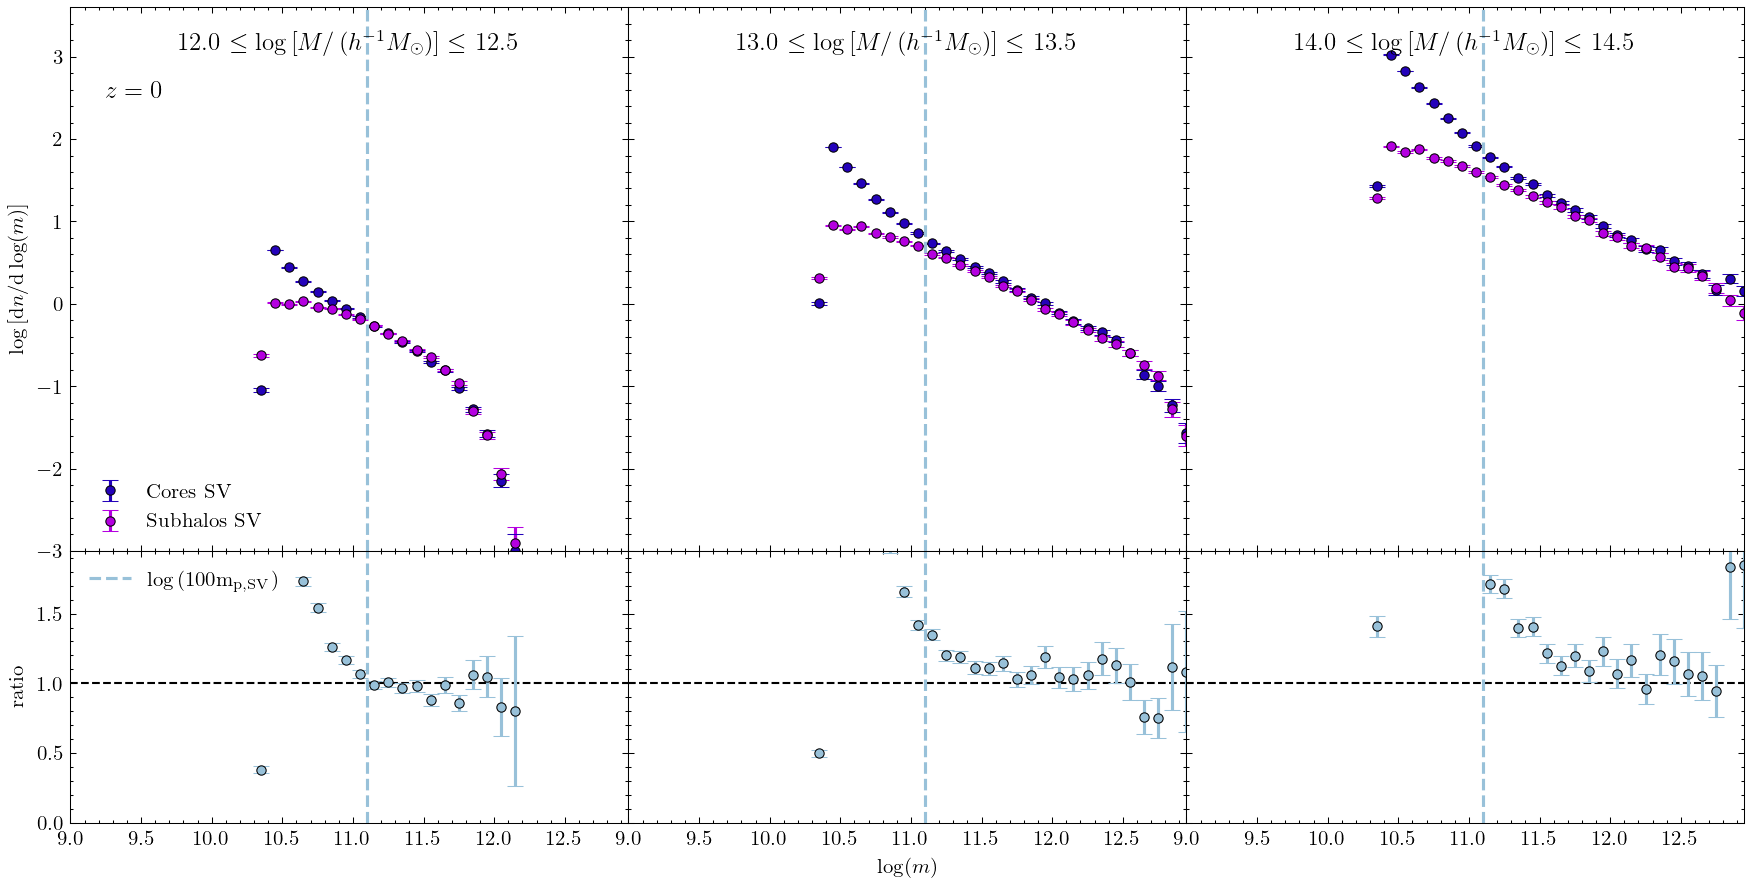

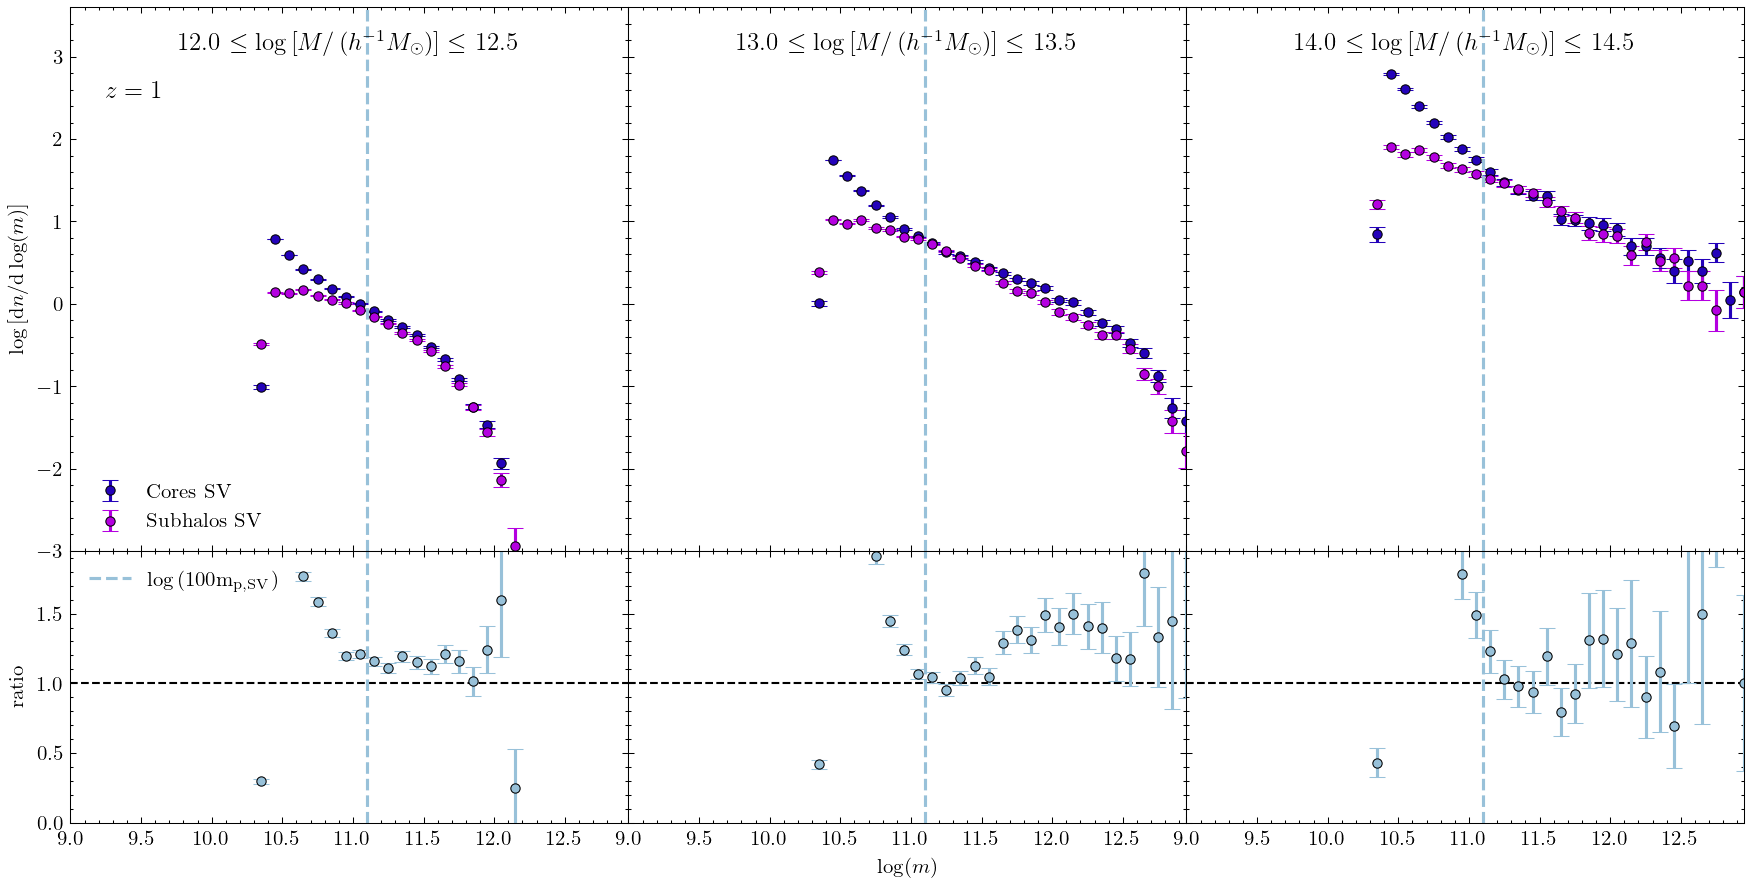

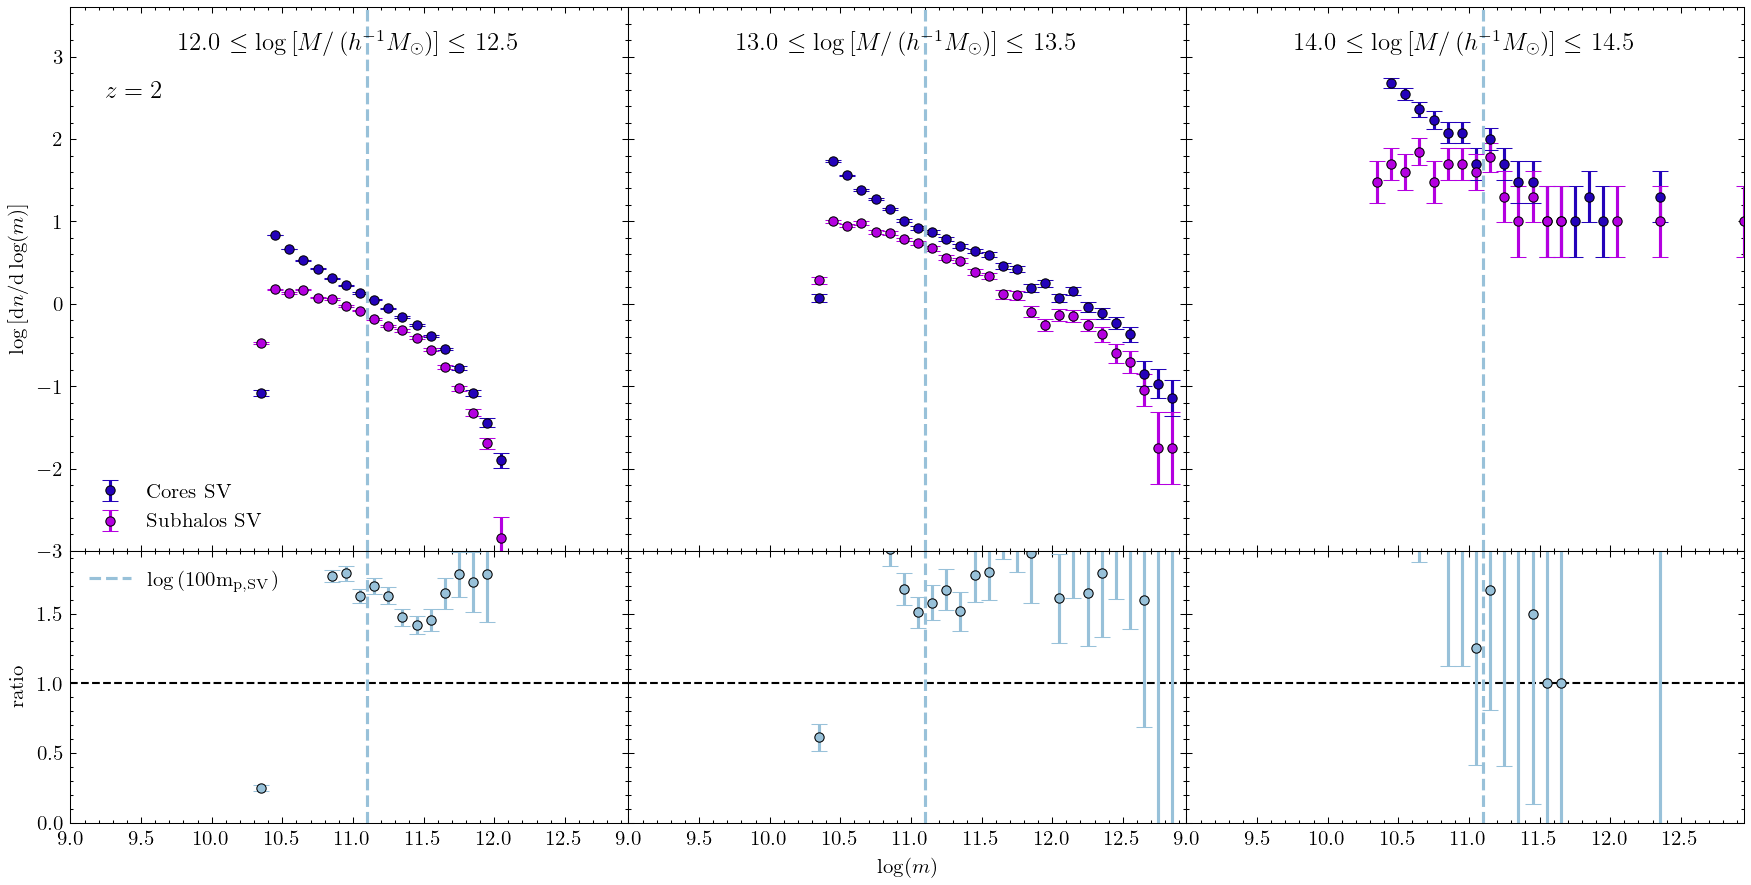

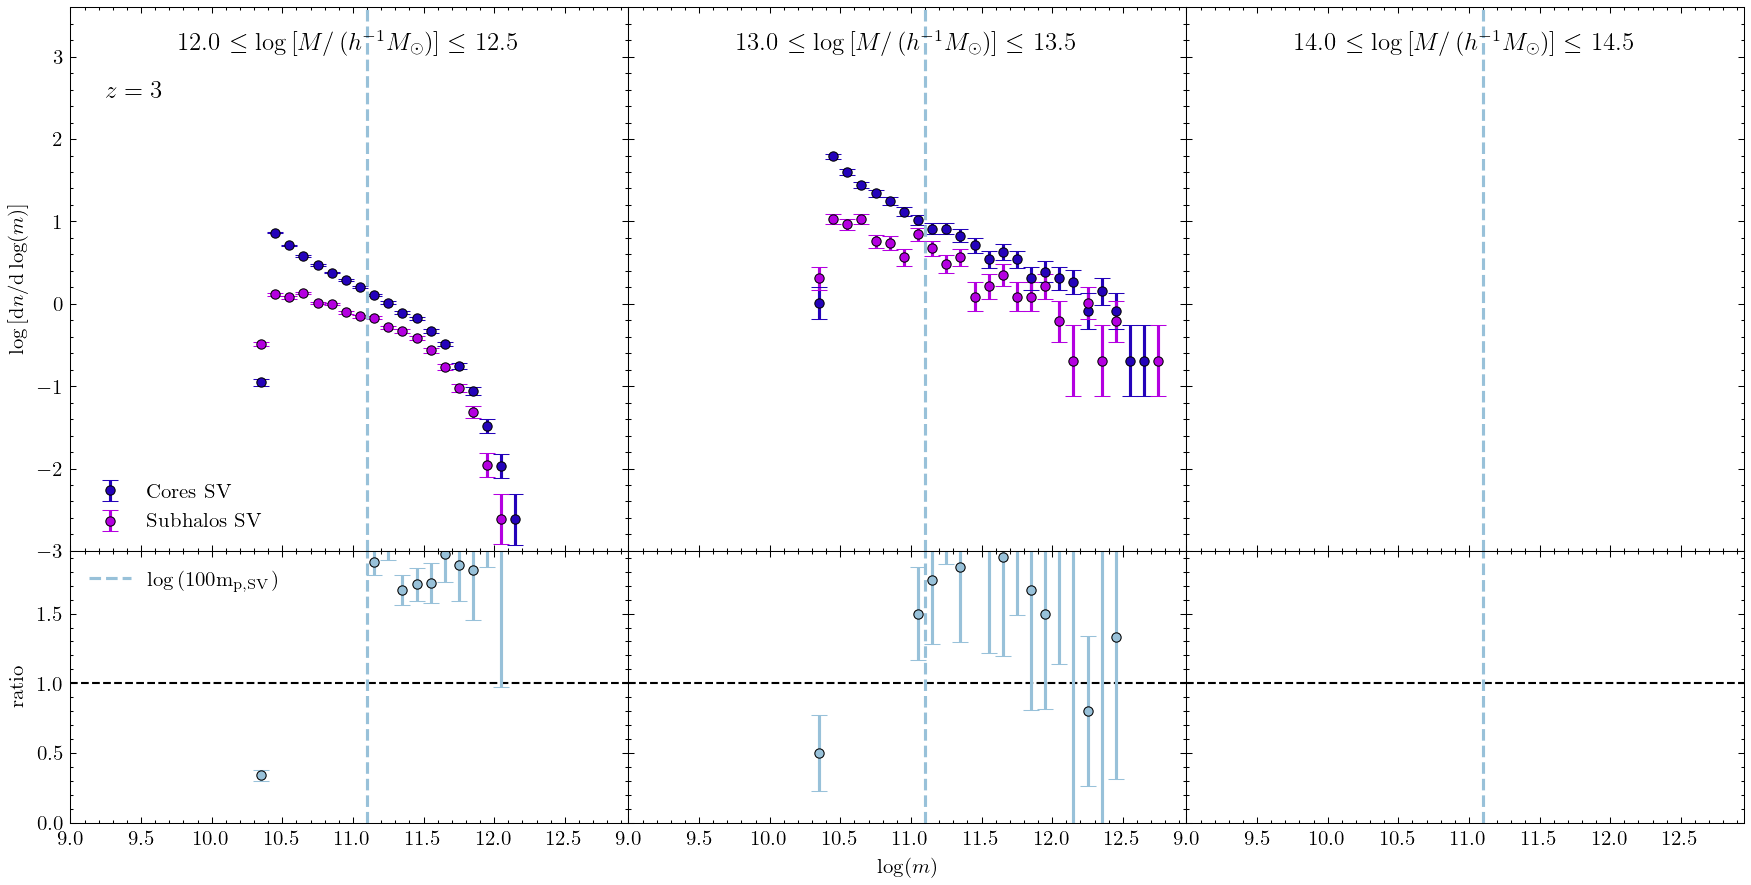

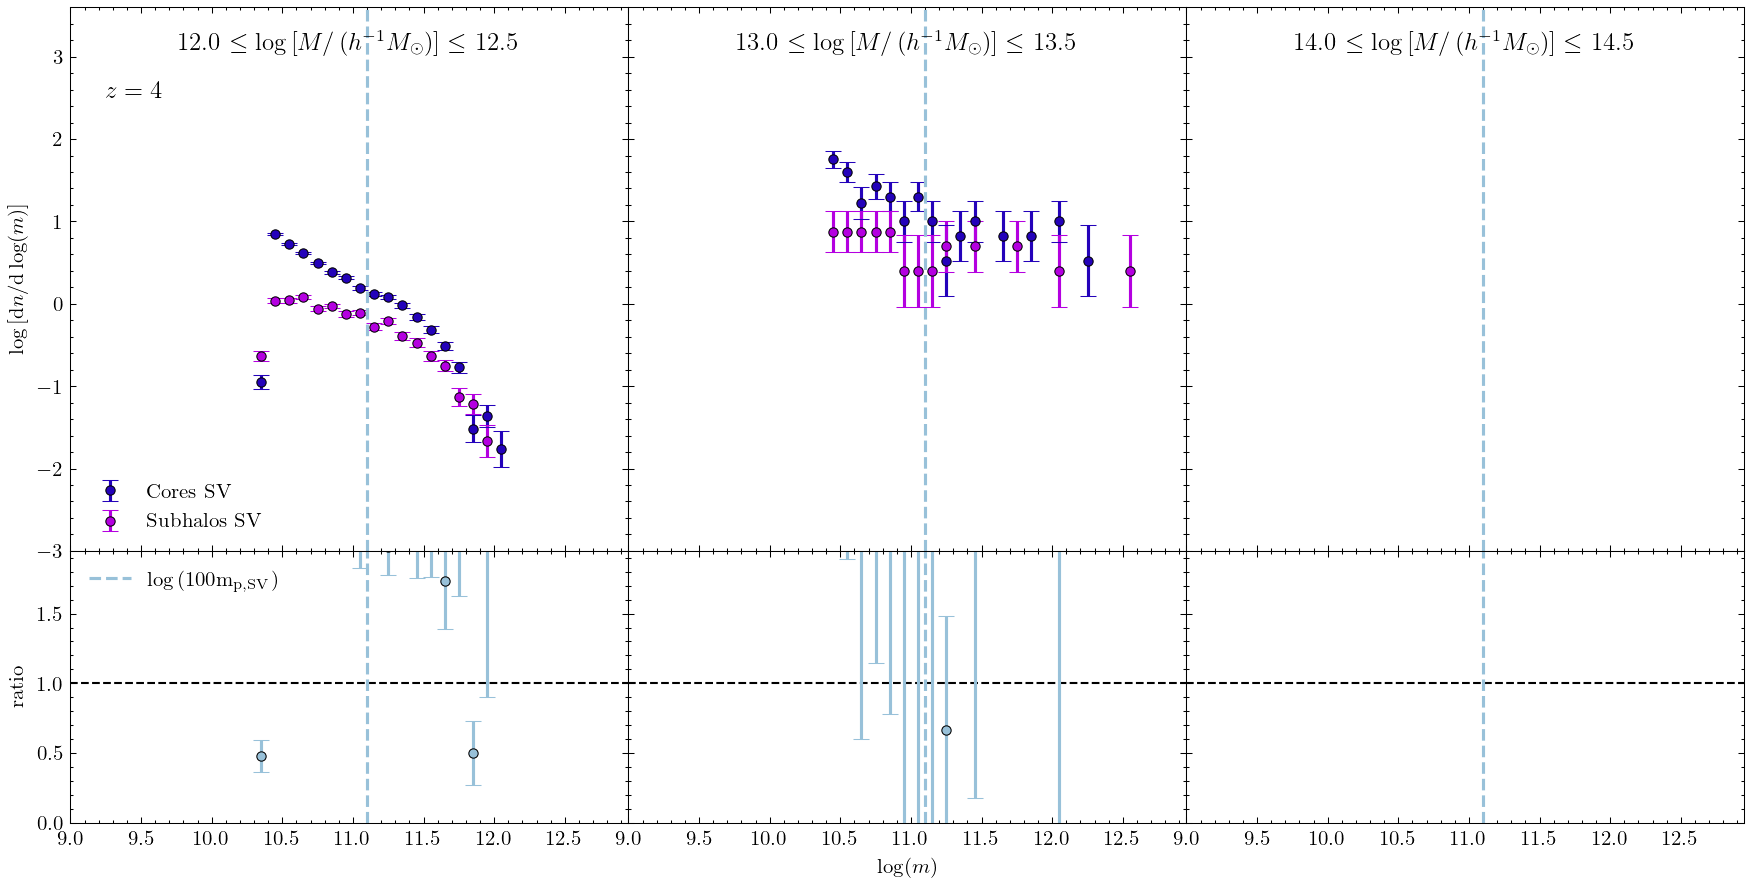

In [53]:
for cc_SV, sh_SV, centrals_mask_SV, zlabel in [(cc_SV0, sh_SV0, centrals_mask_SV0, '$z=0$'), (cc_SV1, sh_SV1, centrals_mask_SV1, '$z=1$'), (cc_SV2, sh_SV2, centrals_mask_SV2, '$z=2$'), (cc_SV3, sh_SV3, centrals_mask_SV3, '$z=3$'), (cc_SV4, sh_SV4, centrals_mask_SV4, '$z=4$')]:
    resolution_tests_highz(cc_SV, sh_SV, centrals_mask_SV, mplot=True, zlabel=zlabel, smallRatioYaxis=True, assert_nH=False)#, dlM=0.5, logMlist=(12,13,14), )    

SV nH cores 40628
Mavg (cores centrals): 1.7033924e+12
SV nH_sh 40628
SV number of subhalos in bin 35236
Mavg (sh centrals): 1.7033923415564163e+12
6.0385137425623816e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV lim: -1.134210603304881


/home/isultan/miniconda3/envs/smacc/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in subtract


SV nH cores 4797
Mavg (cores centrals): 1.6754464e+13
SV nH_sh 4797
SV number of subhalos in bin 36337
Mavg (sh centrals): 1.6754462182588432e+13
1.0835104405187458e-05 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV lim: -2.1270264045403824
SV nH cores 337
Mavg (cores centrals): 1.6433545e+14
SV nH_sh 337
SV number of subhalos in bin 21791
Mavg (sh centrals): 1.6433543829330672e+14
5.885759698002493e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV lim: -3.118627140414612
ax1 YLIM (-2.3, 3.8)
SV nH cores 34592
Mavg (cores centrals): 1.6771427e+12
SV nH_sh 34592
SV number of subhalos in bin 39698
Mavg (sh centrals): 1.6771425055584014e+12
8.909057607314903e-06 percent relative difference between Mavg_cores and Mavh_sh

RELDIF: 0.0%
SV lim: -1.1274658788317269
SV nH cores 2418
Mavg (cores centrals): 1.6287099e+13
SV nH_sh 2418
SV number of subhalos in bin 21618
Mavg (sh centrals): 1.6287098271249545e+13
4.441788383436948e-06 perc

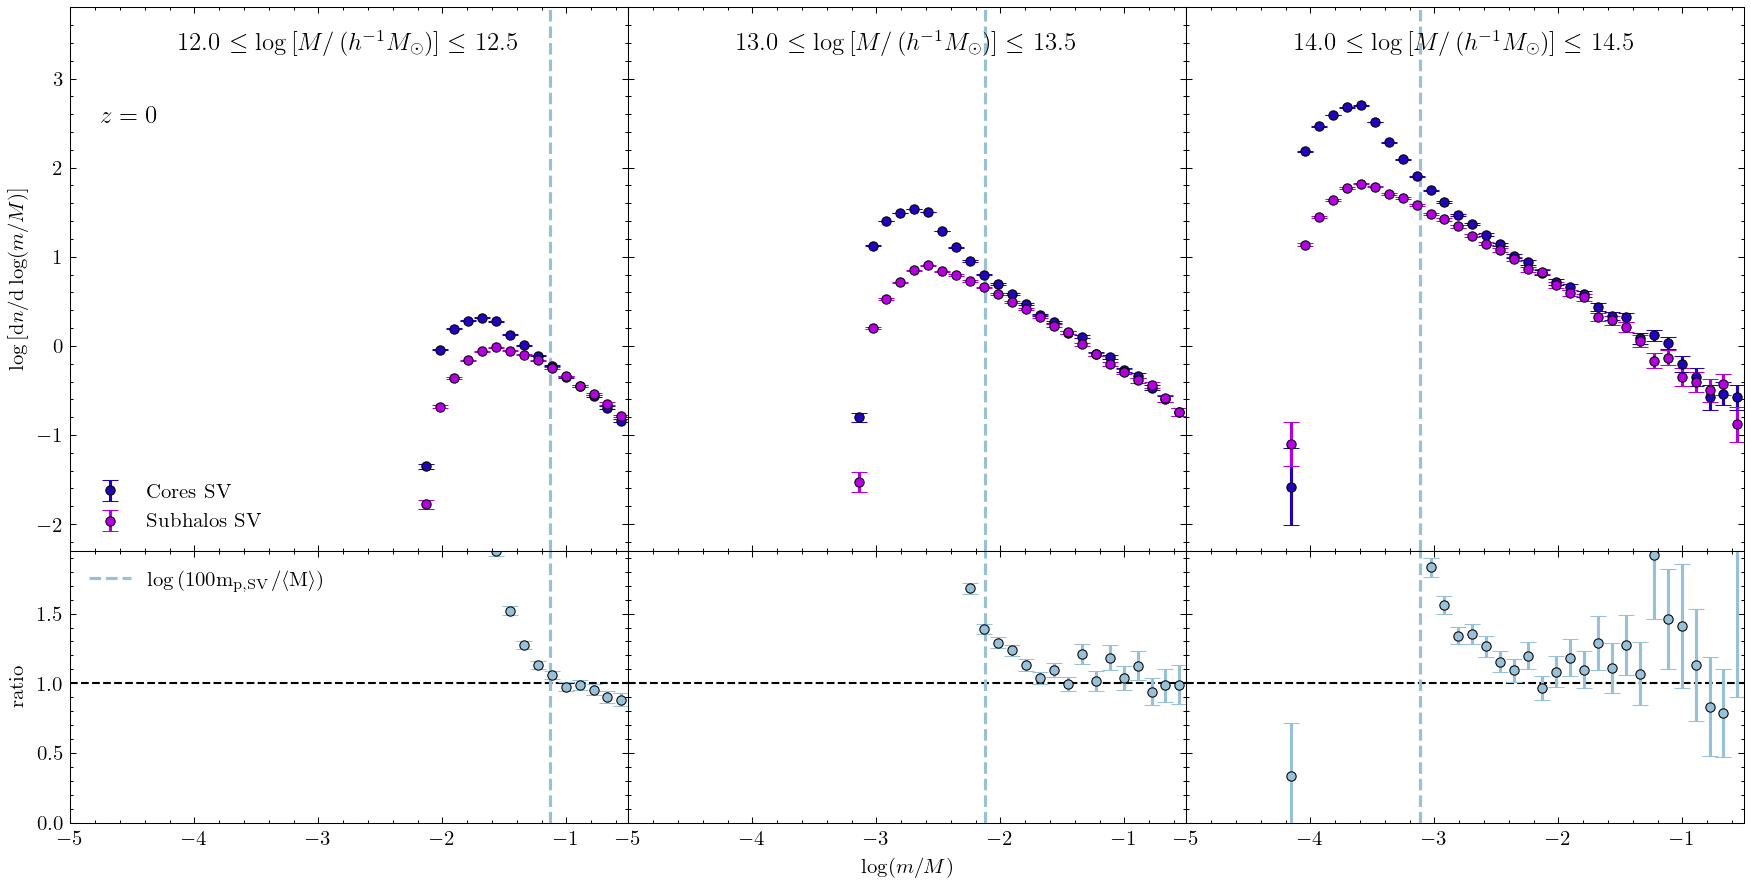

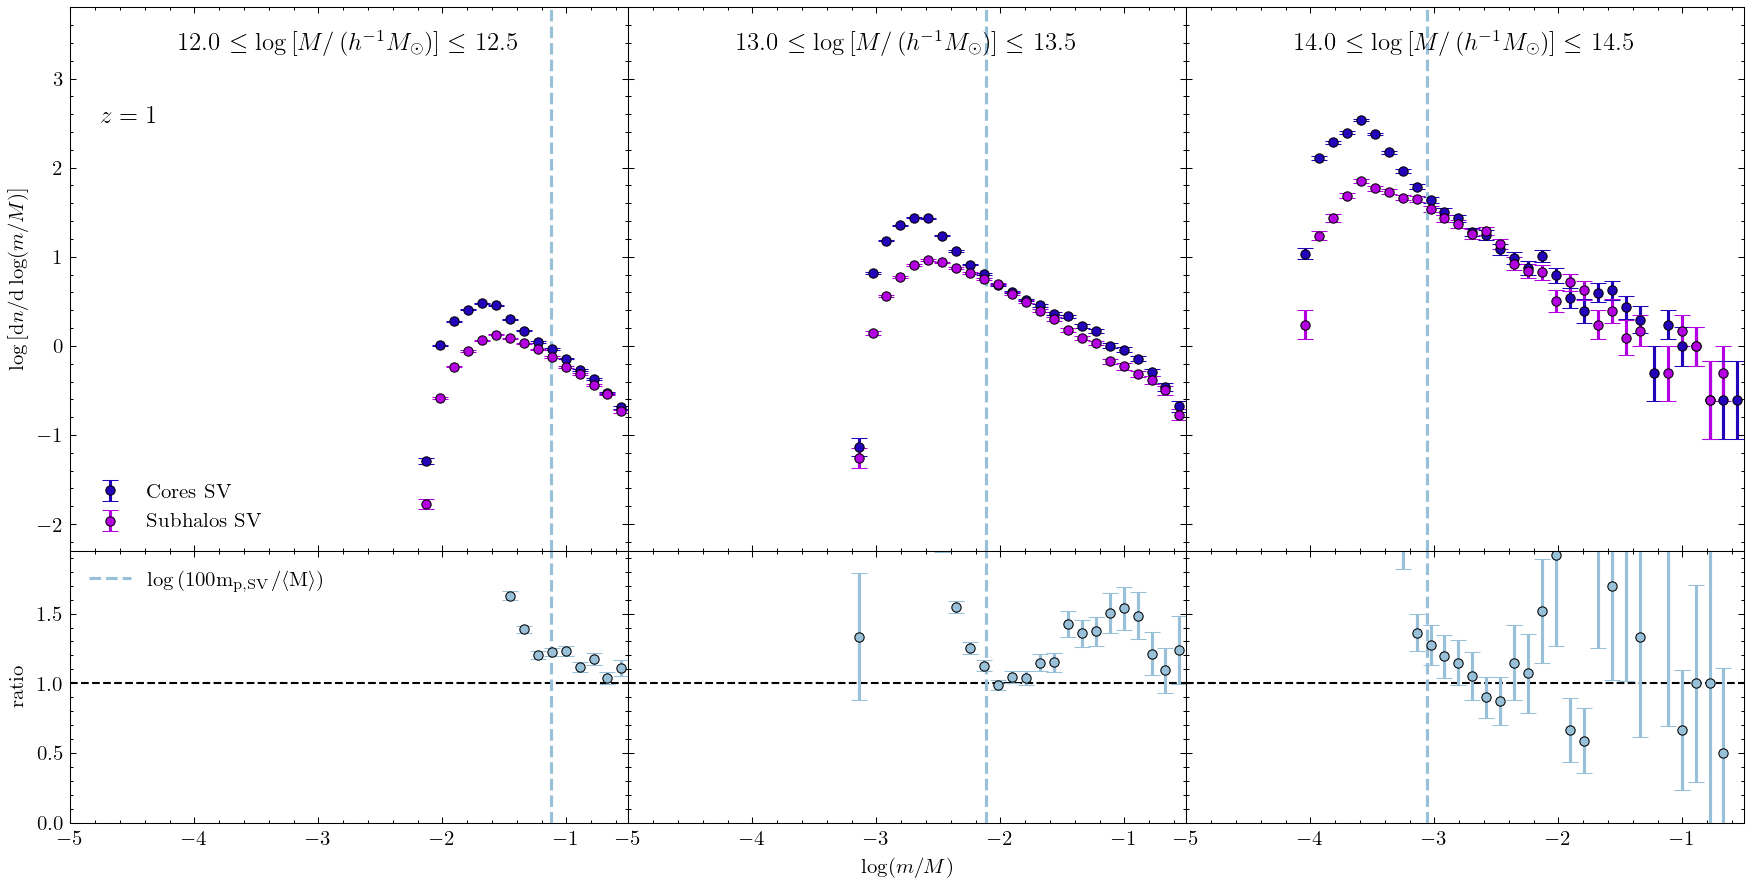

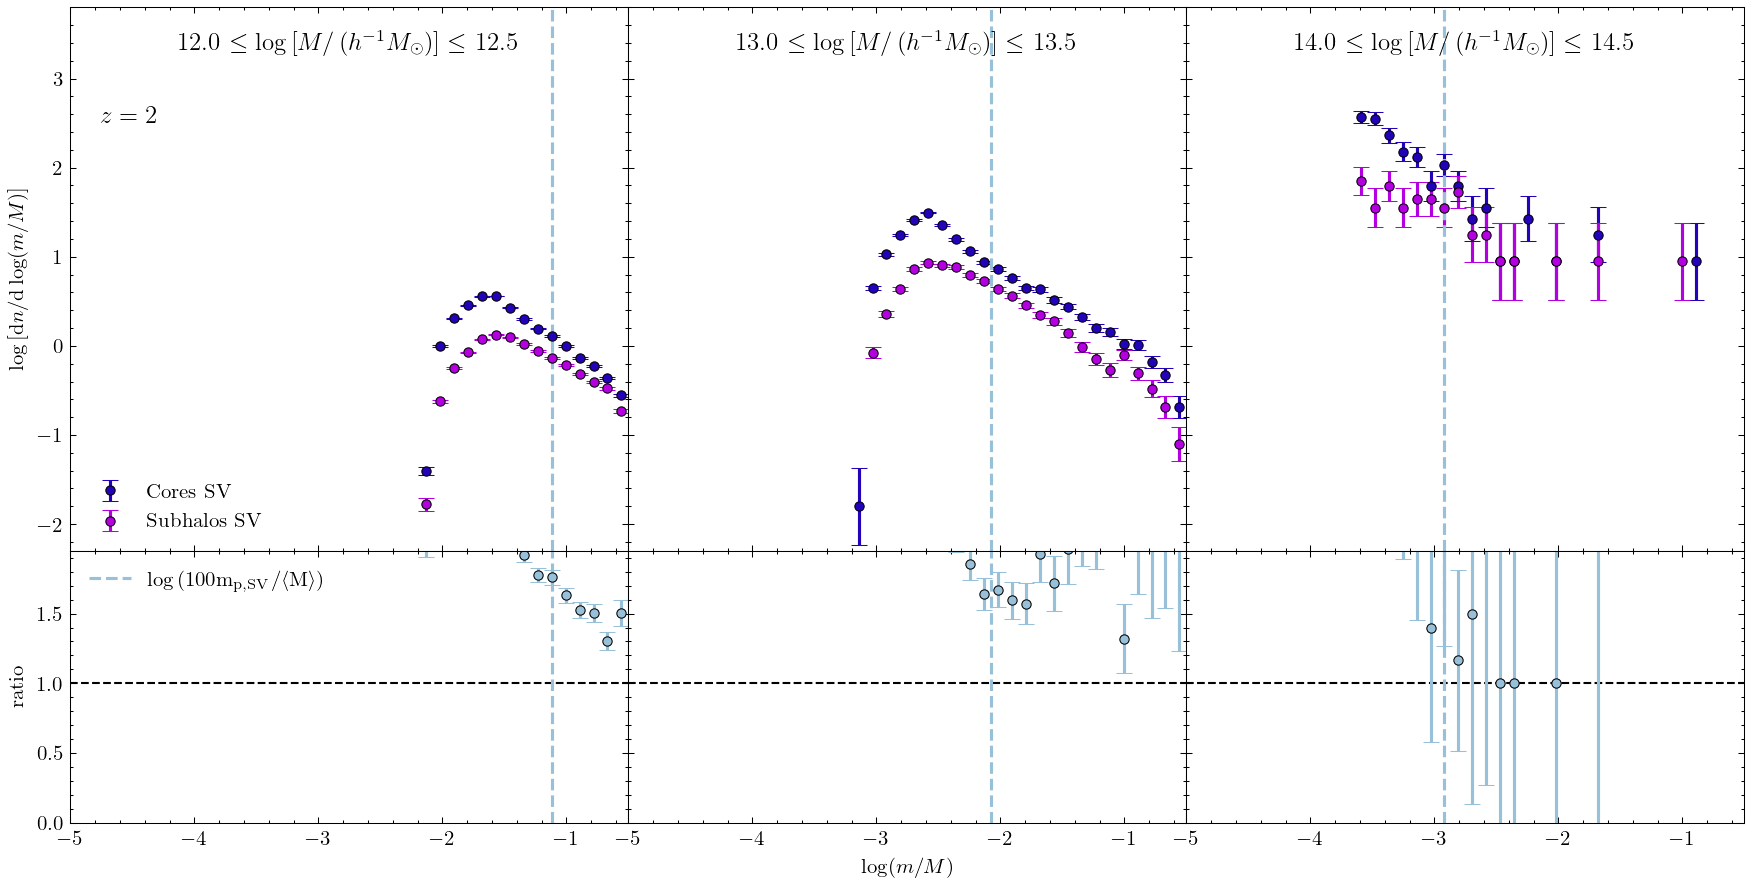

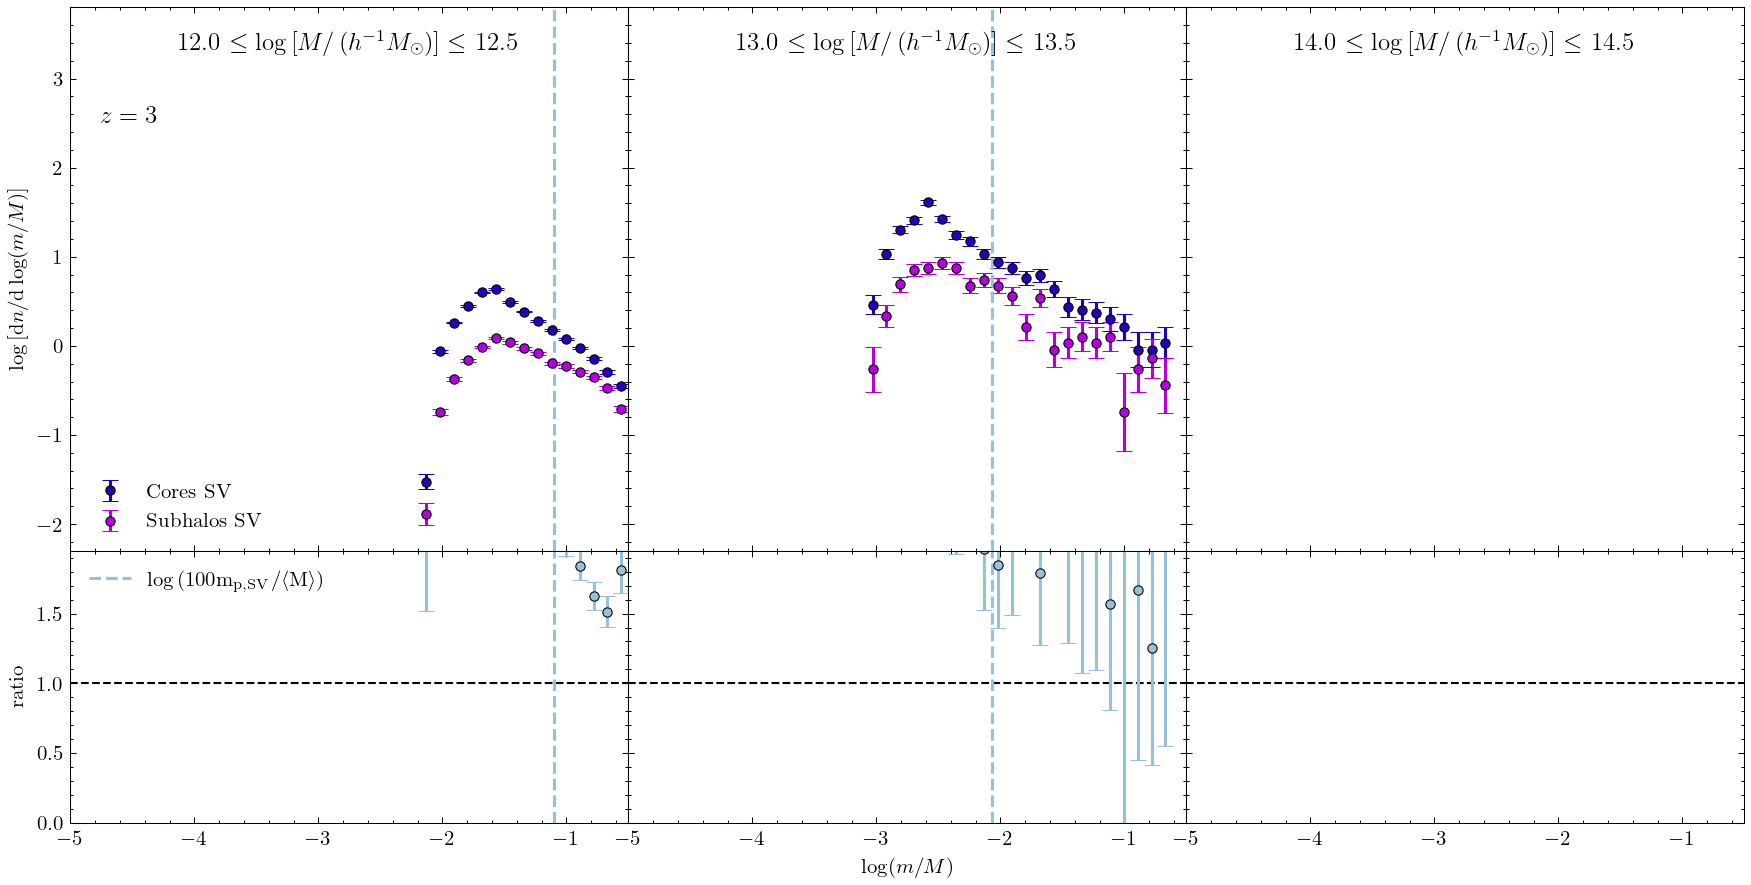

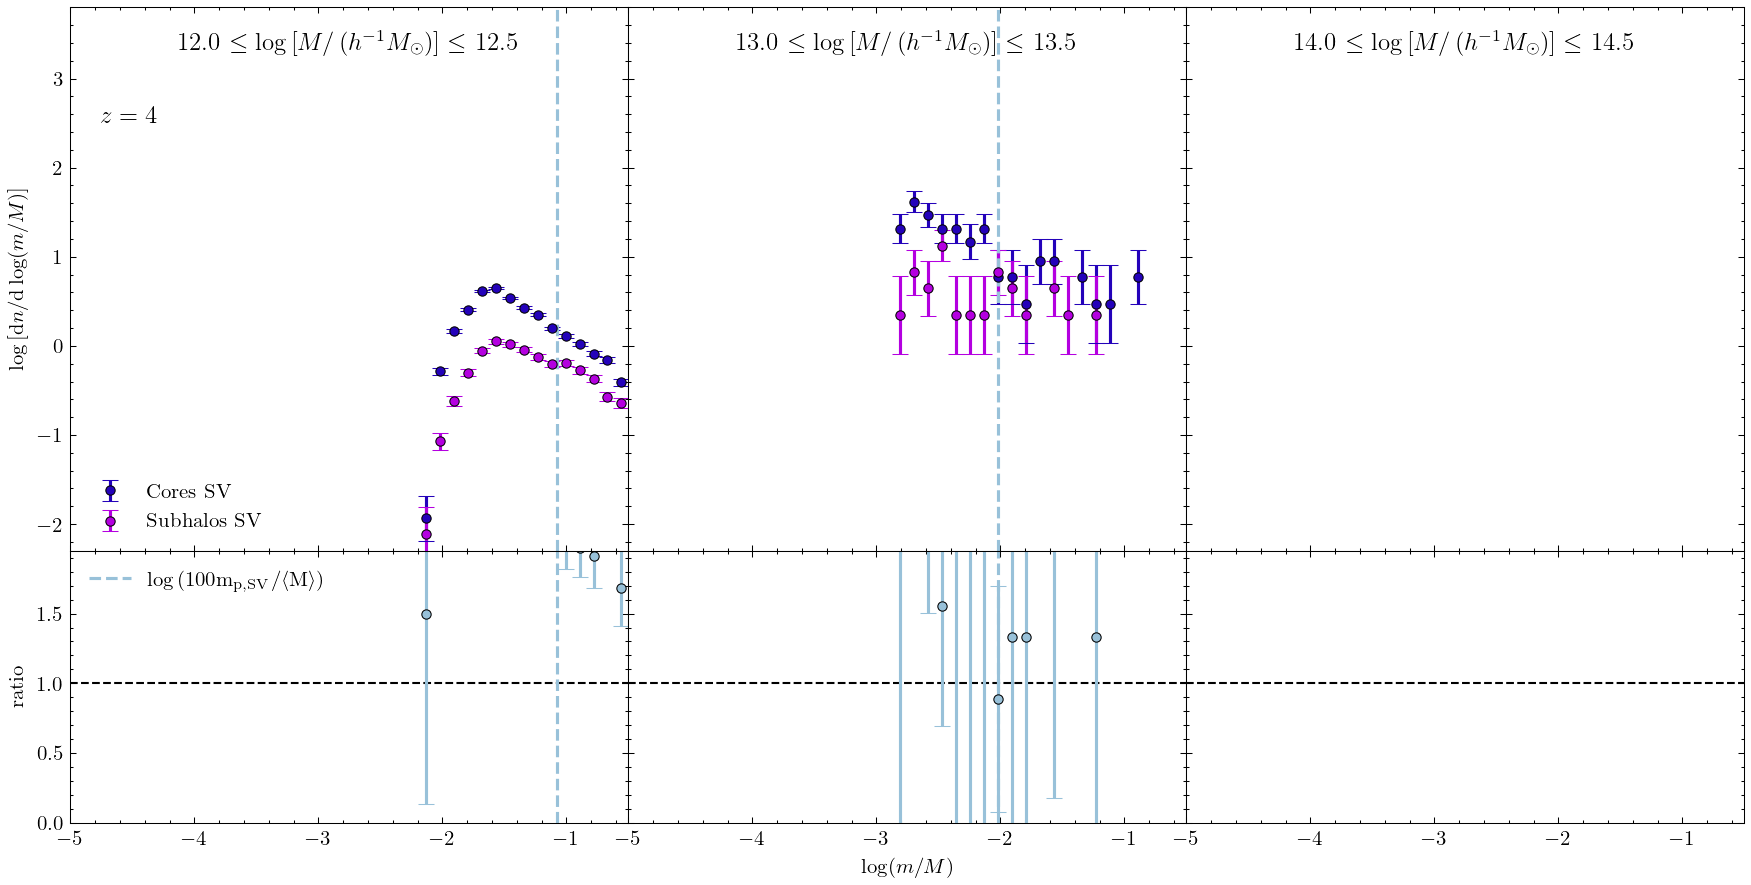

In [54]:
for cc_SV, sh_SV, centrals_mask_SV, zlabel in [(cc_SV0, sh_SV0, centrals_mask_SV0, '$z=0$'), (cc_SV1, sh_SV1, centrals_mask_SV1, '$z=1$'), (cc_SV2, sh_SV2, centrals_mask_SV2, '$z=2$'), (cc_SV3, sh_SV3, centrals_mask_SV3, '$z=3$'), (cc_SV4, sh_SV4, centrals_mask_SV4, '$z=4$')]:
    resolution_tests_highz(cc_SV, sh_SV, centrals_mask_SV, zlabel=zlabel, smallRatioYaxis=True, assert_nH=False)#, dlM=0.5, logMlist=(12,13,14), )    

## Hiroshima et al. 2018

In [59]:
def A_H18(M, z):
    return np.power(10, (-0.0003*np.log10(M)+0.02)*z + 0.011*np.log10(M) - 0.354)

In [60]:
def zeta_H18(M, z):
    return (0.00012*np.log10(M)-0.0033)*z - 0.0011*np.log10(M) + 0.026

In [65]:
zarr_H18 = np.linspace(0,7)

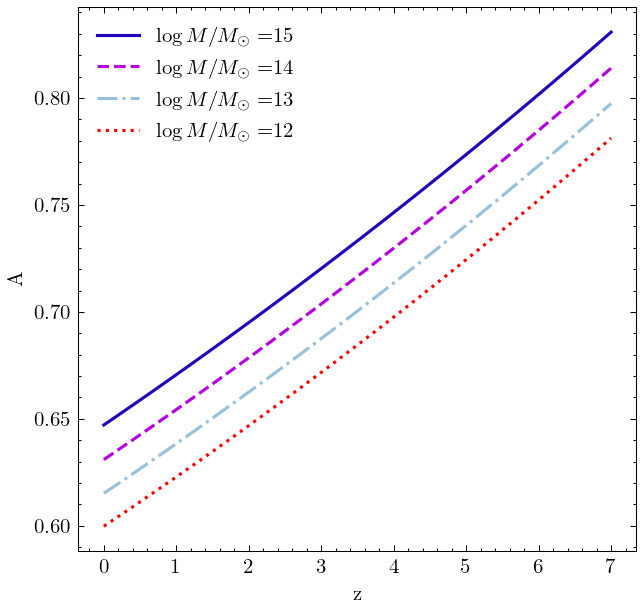

In [86]:
plt.xlabel('z')
plt.ylabel('A')

for lM in (15, 14, 13, 12):
    plt.plot(zarr_H18, A_H18(10**lM, zarr_H18), label='$\log M/M_{\odot}=$'+str(lM))
plt.legend()

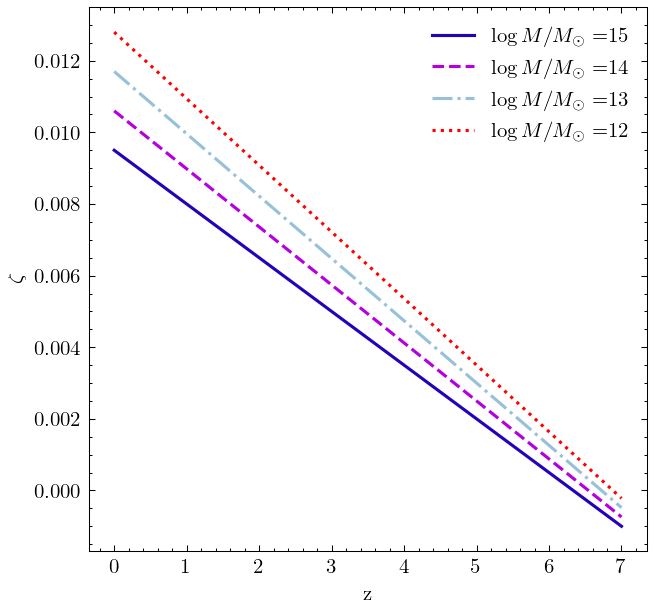

In [85]:
plt.xlabel('z')
plt.ylabel('$\zeta$')

for lM in (15, 14, 13, 12):
    plt.plot(zarr_H18, zeta_H18(10**lM, zarr_H18), label='$\log M/M_{\odot}=$'+str(lM))
plt.legend()